In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import bmxobs
from matplotlib.colors import LogNorm
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

In [2]:
#d = bmxobs.BMXObs("pas/210603_0600", channels="110,220,120")
d1 = bmxobs.BMXObs("pas/210618_0500", channels="110,220,120")
#d2 = bmxobs.BMXObs("pas/190425_0800", channels="110,220,120")
#d3 = bmxobs.BMXObs("pas/210626_0400", channels="110,220,120")

In [3]:
def get_cross_cut (D, fmin, fmax, ravg=10, ramin = 5.23-0.18, ramax=5.23+0.18, chan=120):
    freqcut = np.where((D.freq[0]>fmin) & (D.freq[0]<fmax))[0]
    data = D[chan][:,freqcut]
    # average in freq
    data = data.mean(axis=1)
    racut = np.where((D.ra>ramin) & (D.ra<=ramax))[0]
    racut = racut[:len(racut)//ravg*ravg]
    # average in ra
    data = data[racut]
    data=data.reshape((-1,ravg)).mean(axis=1)
    ra = D.ra[racut].reshape((-1,ravg)).mean(axis=1) 
    ra = np.unique(ra, axis = 0)
    return ra,data/1e11
    

In [4]:
# 21 06 03
ra, data = get_cross_cut(d1,1102,1106)
#ra_2,data_2 = get_cross_cut(d,1500,1505)

## 21 06 18
#ra1, data1 = get_cross_cut(d1,1400,1405)

# 19 04 25
#ra2, data2 = get_cross_cut(d2, 1400, 1405)

# 21 06 26
##ra3, data3 = get_cross_cut(d3, 1100, 1110)

# data.shape

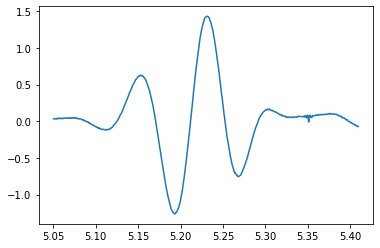

In [5]:
# plt.plot(ra,np.imag(data))
plt.plot(ra,np.real(data))

In [6]:
class Fitter:
    def __init__ (self, ra, data):
        self.ra = ra
        self.data = data
        self.cyg_ra = 5.233
    def minimize(self, startguess):
        self.startfitmodel = self.cross_model(*startguess)
        #sol = least_squares(self._residuals, startguess, method='lm',xtol=1e-2)
        sol = minimize(self.chi2, startguess,method='powell')
        #sol = basinhopping(self.chi2, startguess)
        self.bestfit = sol.x
        f.bestchi2 = self.chi2(sol.x)
        self.bestfitmodel = self.cross_model(*sol.x)
        return self.bestchi2
    
    def robust_minimize(self, sfreq=60):
        Aguess = np.abs(f.data).max()
        guess = [self.cyg_ra, 0.0, 0.0, Aguess, 0, 0, .05]
        bestchi2 = 1e6
        for phase in np.arange(8)*2*np.pi/8:
            for freq in np.linspace(sfreq-20, sfreq+20,5):
                guess[4:6] = phase, freq
                chi2=self.minimize(guess)
                print (f"{phase:.3e} {freq:.3e} chi2 = {chi2}")
                if chi2<bestchi2:
                    bestchi2 = chi2
                    bestfit = self.bestfit
        
        self.bestchi2 = bestchi2
        self.bestfit= bestfit
        self.bestfitmodel = self.cross_model(*self.bestfit)
                
    
    def chi2_2 (self,x):
        guess = self.startguess
        guess[4:6] = x
        chi2 = self.chi2(guess)
            #print (x,'{0:.16f}'.format(chi2))
        return self.chi2(guess)
        
    def minimize2 (self, startguess):
        self.startguess=startguess
        
        sol = basinhopping(self.chi2_2, startguess[4:6])
        return sol.x
    
    def _residuals (self, x):
        model = self.cross_model(*x)
        diff = model-self.data
        diffreal = np.hstack((np.real(diff), np.imag(diff)))
        #print (x,np.sum(diffreal**2))
        return np.real(diff)
    
    
    def cross_model(self, ra0, ofsreal, ofsimag, A, phi, omega, sigma):
        return ofsreal+1j*ofsimag+A*np.exp(-1j*(phi+omega*(self.ra-self.cyg_ra)))*np.exp(-(self.ra-ra0)**2/(2*sigma**2))

    def chi2(self,x):
        model = self.cross_model(*x)
        diff = self.data-model
        chi2 = (np.real(diff)**2).sum()+(np.imag(diff)**2).sum()
        #print(chi2)
        return chi2

In [7]:
f=Fitter(ra,data)
f.robust_minimize(60)

0.000e+00 4.000e+01 chi2 = 230.76513671875
0.000e+00 5.000e+01 chi2 = 2.9985456466674805
0.000e+00 6.000e+01 chi2 = 2.998579978942871
0.000e+00 7.000e+01 chi2 = 2.998546600341797
0.000e+00 8.000e+01 chi2 = 2.9985544681549072
7.854e-01 4.000e+01 chi2 = 230.76513671875
7.854e-01 5.000e+01 chi2 = 230.76513671875
7.854e-01 6.000e+01 chi2 = 2.9985456466674805
7.854e-01 7.000e+01 chi2 = 2.9985499382019043
7.854e-01 8.000e+01 chi2 = 2.9985604286193848
1.571e+00 4.000e+01 chi2 = 230.76513671875
1.571e+00 5.000e+01 chi2 = 230.76513671875
1.571e+00 6.000e+01 chi2 = 230.76513671875
1.571e+00 7.000e+01 chi2 = 230.76513671875
1.571e+00 8.000e+01 chi2 = 230.76513671875
2.356e+00 4.000e+01 chi2 = 129.06011962890625
2.356e+00 5.000e+01 chi2 = 129.03005981445312
2.356e+00 6.000e+01 chi2 = 129.0545196533203
2.356e+00 7.000e+01 chi2 = 129.01296997070312
2.356e+00 8.000e+01 chi2 = 126.69152069091797
3.142e+00 4.000e+01 chi2 = 129.0167236328125
3.142e+00 5.000e+01 chi2 = 128.9979705810547
3.142e+00 6.000e+

In [8]:
vals = f.bestfit
names = 'ra0, ofsreal, ofsimag, A, phi, omega, sigma'.split()
for n,v in zip(names,vals):
    print (f"{n} = {v:.3e}")
print ("chi2=", f.bestchi2)

ra0, = 5.215e+00
ofsreal, = 2.955e-02
ofsimag, = 1.848e-03
A, = 1.401e+00
phi, = 1.145e-01
omega, = 7.659e+01
sigma = 4.654e-02
chi2= 2.9985456


Text(0.5, 1.0, 'Real')

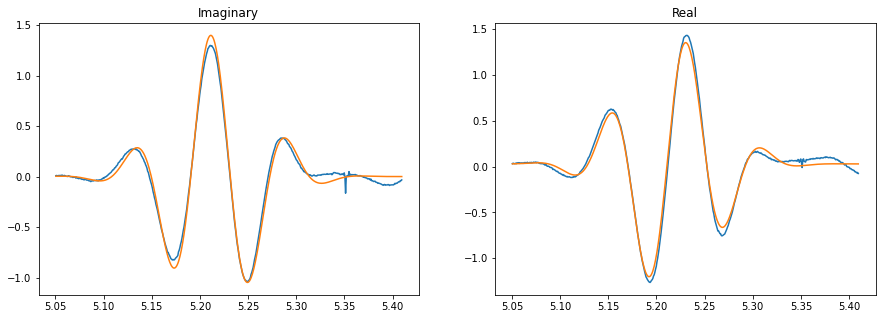

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(ra, np.imag(data))
ax1.plot(ra, np.imag(f.bestfitmodel))
ax1.set_title('Imaginary')

ax2.plot(ra, np.real(data))
ax2.plot(ra, np.real(f.bestfitmodel))
#ax2.plot(ra, np.real(f.startfitmodel))
ax2.set_title('Real')
